###Import libraries

In [1]:
!pip install xgboost
!pip install lightgbm

In [28]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as pipe
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import precision_recall_curve, roc_curve, auc

import pandas as pd
import numpy as np

from numpy import mean
from numpy import std

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')
#Lightgbm, catboost, xgboost, svm, Randomforest
#Try stacking models
#RNN, LSTM, Bi-directional, Transformer and attention models

##Preprocessing Steps
# The Original dataset was processed in the following fashion:

1. The Redundant columns were removed.
2. The categorical columns were one-hot encoded
3. The Description column was TFIDVectorized
4. Synthetic data was generated using SMOTE

##Utility functions to execute models, transform columns, plot roc curves etc.,

In [3]:
def readData(filename):
  df = pd.read_csv(filename)
  print(df.shape)
  label = df["Accident Level"]
  df.drop('Accident Level', inplace=True, axis=1)
  df.drop('Unnamed: 0', inplace=True, axis=1)
  df.drop('Day', inplace=True, axis=1)
  df.drop('WeekofYear', inplace=True, axis=1)

  return df, label

In [ ]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


In [4]:
results = []
metrics = pd.DataFrame(results, columns=["Approach","Model","Class","Precision","Recall", "ROC AUC", "PR AUC"])

#Functions to plot ROC and AUC curves
def plotcurves(y_test, y_score, approach=None, modelname=None):
  global metrics

  classes=[1,2,3,4,5]
  y_test = label_binarize(y_test, classes)

  # precision recall curve
  precision = dict()
  recall = dict()
  for i in classes:
      precision[i], recall[i], _ = precision_recall_curve(y_test[:, i-1], y_score[:, i-1])
      plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
      
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("precision vs. recall curve")
  filename = "/content/plots/" + approach + "_" + modelname + "_" + "PR_curve" + ".png"
  #plt.savefig(filename, bbox_inches='tight') 
  #plt.close() 
  plt.show()
 
  # roc curve
  fpr = dict()
  tpr = dict()
  
  for i in classes:
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i-1], y_score[:, i-1])
      plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))
      metrics = metrics.append({'Approach':approach, 'Model':modelname, 'Class':i, 'Precision':np.mean(precision[i]), 'Recall':np.mean(recall[i]), 'ROC AUC': auc(fpr[i], tpr[i]), 'PR AUC':auc(recall[i], precision[i])}, ignore_index=True)

  plt.xlabel("false positive rate")
  plt.ylabel("true positive rate")
  plt.legend(loc="best")
  plt.title("ROC curve")
  filename = "/content/plots/" + approach + "_" + modelname + "_" + "ROC_curve" + ".png"
  #plt.savefig(filename, bbox_inches='tight')
  #plt.close()
  plt.show() 


In [5]:
X, y = readData("Processed.csv")

#Transform the data
#Using Column Transformer
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object','category']).columns

columnTransformer = ColumnTransformer(
    [('O', OneHotEncoder(dtype='int',handle_unknown='ignore'), ["Country","Local","Industry Sector","Gender","Employee Type","Critical Risk"]),
     ('tfid', TfidfVectorizer(max_features=1000, stop_words='english', max_df=0.9, ngram_range=(1,2)), "Description")],
    remainder='passthrough', sparse_threshold=0
)

(418, 16)


In [6]:
frame = pd.DataFrame(results, columns=["Approach","Model","Accuracy"])

#Function to execute a particular model with the pipeline
def executeModel(approach, model, modelname, X_train, y_train, X_test, y_test, useColumnTransformer=False):
  global frame
  steps = list()
  if(useColumnTransformer):
    steps.append(('columntransformer', columnTransformer))
  #steps.append((modelname, OneVsRestClassifier(model)))
  steps.append((modelname, model))

  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  pipeline = Pipeline(steps=steps)

  pipeline.fit(X_train, y_train)

  #Cross validated Accuracy
  scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

  print(modelname)
  print("Training Accuracy:")
  print(np.mean(scores))
  print("Testing Accuracy:")
  testscores = cross_val_score(pipeline, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
  print(np.mean(testscores))


  frame = frame.append({'Approach':approach, 'Model':modelname, 'Accuracy':np.mean(scores)}, ignore_index=True)

  score = np.mean(scores)

  #Predict against Test data
  y_pred = cross_val_predict(pipeline, X_test, y_test, cv=3, method='predict_proba')

  #y_pred = pipeline.predict_proba(X_test)

  plotcurves(y_test, y_pred, approach, modelname)
  
  labels = [1,2,3,4,5]
  y_pred_arr = []
  y_test_arr = []
  for item in y_pred:
    y_pred_arr.append(labels[np.argmax(item)])

  for item in y_test:
    y_test_arr.append(item)

  print(classification_report(y_test_arr, y_pred_arr))

In [7]:
def executeAllModels(approach, models, X_train, y_train, X_test, y_test, useColumnTransformer=True):
  for modelname, model in models.items():
    executeModel(approach, model, modelname, X_train, y_train, X_test, y_test, useColumnTransformer)

##Approach 1: Run the models on the Augmented dataset (No SMOTE)

In [198]:
X, y = readData("Final_Augmented_data.csv")
label = y 
#y = preprocessing.label_binarize(y, classes=[1,2,3,4,5])

print(X.shape)
print(label.shape)

(658, 16)
(658, 12)
(658,)


In [199]:
#Test Train splitting
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size = 0.1, random_state = 42) 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(592, 12)
(592,)
(66, 12)
(66,)


###Grid Search with RandomForestClassifier

In [200]:
steps = list()
steps.append(('columntransformer', columnTransformer))
steps.append(('model', RandomForestClassifier()))
pipeline = Pipeline(steps=steps)

In [201]:
n_estimators = [100]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
param_grid = {'model__n_estimators':n_estimators, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = GridSearchCV(pipeline, param_grid = param_grid, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [202]:
grid_result = grid.fit(X_train, y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  4.1min finished


In [203]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_)) # report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.895205 using {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


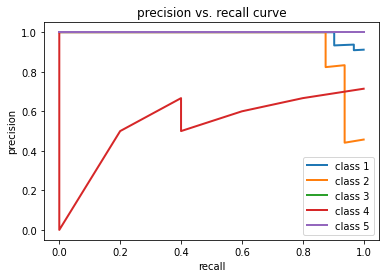

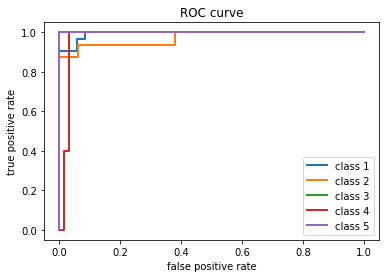

In [204]:
y_pred = grid.predict_proba(X_test)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

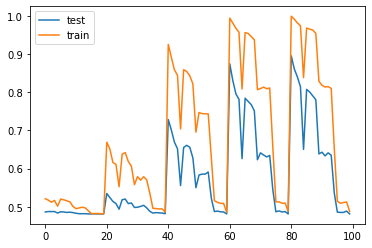

In [205]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

###Grid Search with ExtraTreesClassifier

In [206]:
steps = list()
steps.append(('columntransformer', columnTransformer))
steps.append(('model', ExtraTreesClassifier()))
pipeline = Pipeline(steps=steps)

n_estimators = [100]
criterion = ['gini','entropy']
max_depth = [5, 15, None]
max_features = [5, 10, "sqrt", "log2"]
min_samples_split = [2, 10, 15]
min_samples_leaf = [1, 2, 5]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_features':max_features, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = GridSearchCV(pipeline, param_grid = param_grid, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [207]:
grid_result = grid.fit(X_train, y_train)

Fitting 15 folds for each of 216 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  7.7min finished


In [208]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_)) # report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.941998 using {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


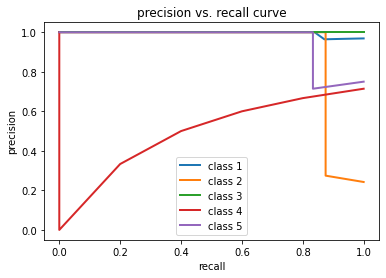

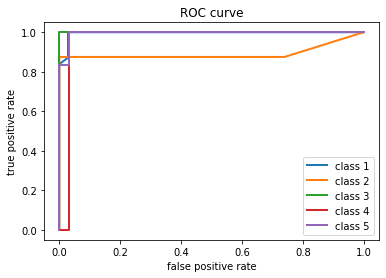

In [209]:
y_pred = grid.predict_proba(X_test)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

###RandomizedSearch with ExtraTrees

In [210]:
steps = list()
steps.append(('columntransformer', columnTransformer))
steps.append(('model', ExtraTreesClassifier()))
pipeline = Pipeline(steps=steps)

n_estimators = [100, 200, 300]
criterion = ['gini','entropy']
max_depth = [5, 15, None]
max_features = [5, 10, "sqrt", "log2"]
min_samples_split = [2, 10, 15]
min_samples_leaf = [1, 2, 5]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_features':max_features, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=10, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [211]:
random_result = random.fit(X_train, y_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   28.4s finished


In [212]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.818117 using {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'entropy'}


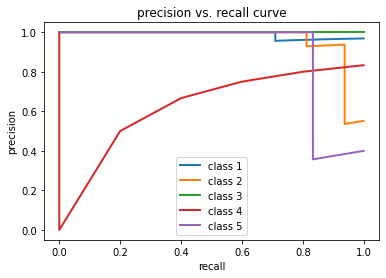

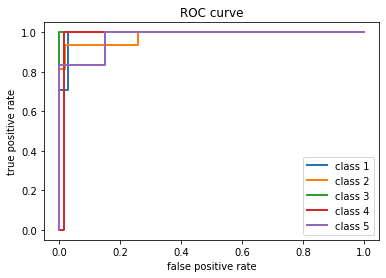

In [213]:
y_pred = random.predict_proba(X_test)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

###RandomizedSearchCV with LightGBMClassifier

In [214]:
steps = list()
steps.append(('columntransformer', columnTransformer))
steps.append(('model', LGBMClassifier()))
pipeline = Pipeline(steps=steps)

n_estimators = [100, 200, 300]
criterion = ['gini','entropy']
max_depth = [5, 15, None]
max_features = [5, 10, "sqrt", "log2"]
min_samples_split = [2, 10, 15]
min_samples_leaf = [1, 2, 5]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_features':max_features, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=10, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [215]:
random_result = random.fit(X_train, y_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   57.3s finished


In [216]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.897507 using {'model__n_estimators': 300, 'model__min_samples_split': 15, 'model__min_samples_leaf': 5, 'model__max_features': 5, 'model__max_depth': None, 'model__criterion': 'gini'}


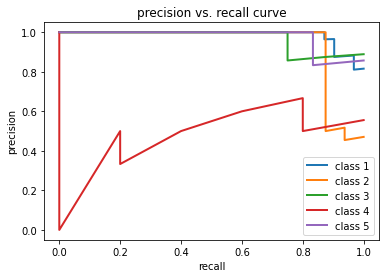

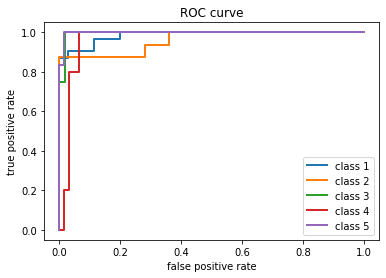

In [217]:
y_pred = random.predict_proba(X_test)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

###RandomizedSearch with RandomForest

In [218]:
steps = list()
steps.append(('columntransformer', columnTransformer))
steps.append(('model', RandomForestClassifier()))
pipeline = Pipeline(steps=steps)

n_estimators = [100, 200, 300]
criterion = ['gini','entropy']
max_depth = [5, 15, None]
max_features = [5, 10, "sqrt", "log2"]
min_samples_split = [2, 10, 15]
min_samples_leaf = [1, 2, 5]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_features':max_features, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=10, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [219]:
random_result = random.fit(X_train, y_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   38.6s finished


In [220]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.833889 using {'model__n_estimators': 300, 'model__min_samples_split': 15, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'entropy'}


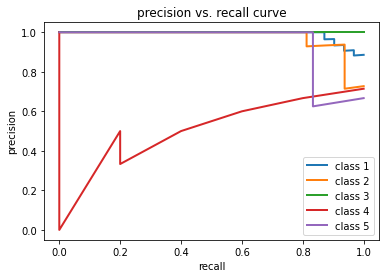

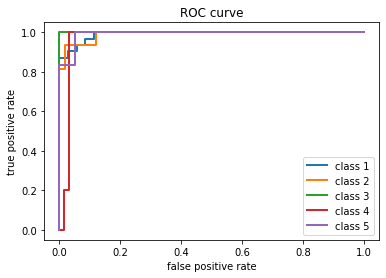

In [221]:
y_pred = random.predict_proba(X_test)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

###RandomizedSearch with XGBClassifier

In [222]:
steps = list()
steps.append(('columntransformer', columnTransformer))
steps.append(('model', XGBClassifier()))
pipeline = Pipeline(steps=steps)

n_estimators = [100, 200, 300]
criterion = ['gini','entropy']
max_depth = [5, 15, None]
max_features = [5, 10, "sqrt", "log2"]
min_samples_split = [2, 10, 15]
min_samples_leaf = [1, 2, 5]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_features':max_features, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=10, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [223]:
random_result = random.fit(X_train, y_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.4min finished


In [224]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.897493 using {'model__n_estimators': 300, 'model__min_samples_split': 15, 'model__min_samples_leaf': 2, 'model__max_features': 5, 'model__max_depth': 5, 'model__criterion': 'gini'}


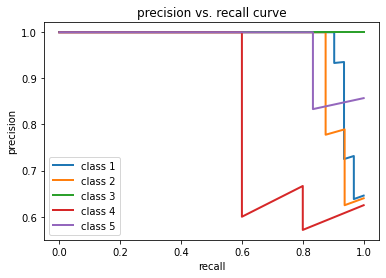

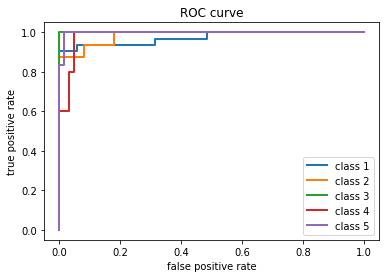

In [225]:
y_pred = random.predict_proba(X_test)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

##Approach 2: Run the models on the original dataset + SMOTE (No Augmentation)

In [226]:
X, y = readData("Processed.csv")
label = y

classes=[1,2,3,4,5]
#Y = label_binarize(y, classes)
Y = y
le = preprocessing.LabelEncoder()
Y = le.fit_transform(y)

Y = label
print(X.shape)
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42) 
print(X_train.shape)
print(y_train.shape)

#Transform the columns
transformer = columnTransformer.fit(X_train)
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

#SMOTE on Training dataset
over = SMOTE()
steps = [('o', over)]
smotepipe = pipe(steps=steps)
# transform the dataset
X_train_smote, y_train_smote = smotepipe.fit_resample(X_train_transformed, y_train)

print(X_train_smote.shape)
print(y_train_smote.shape)

(418, 16)
(418, 12)
(418,)
(313, 12)
(313,)
(1150, 1057)
(1150,)


###RandomizedSearchCV with LightGBM

In [227]:
steps = list()
steps.append(('model', LGBMClassifier()))
pipeline = Pipeline(steps=steps)

n_estimators = [100, 200, 300]
criterion = ['gini','entropy']
max_depth = [5, 15, None]
max_features = [5, 10, "sqrt", "log2"]
min_samples_split = [2, 10, 15]
min_samples_leaf = [1, 2, 5]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_features':max_features, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=10, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [228]:
random_result = random.fit(X_train_smote, y_train_smote)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.1min finished


In [229]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.965507 using {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 10, 'model__max_depth': None, 'model__criterion': 'gini'}


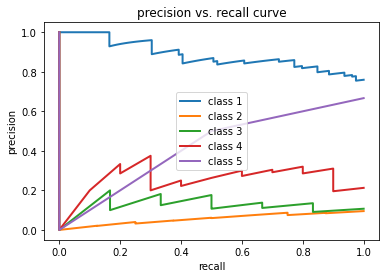

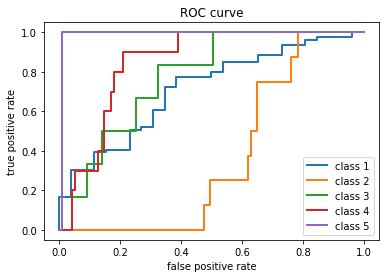

In [230]:
y_pred = random.predict_proba(X_test_transformed)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

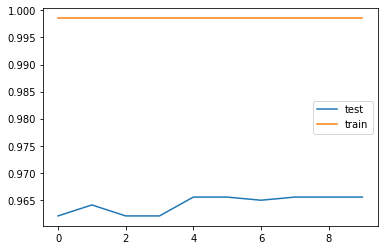

In [231]:
test_scores = random.cv_results_['mean_test_score']
train_scores = random.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [232]:
test_score = random.score(X_test_transformed, y_test)
print(test_score)

0.7047619047619048


###RandomSearchCV with ExtraTreesClassifier

In [233]:
steps = list()
steps.append(('model', ExtraTreesClassifier()))
pipeline = Pipeline(steps=steps)

In [234]:
n_estimators = [100, 200, 300] #changed
criterion = ['gini','entropy']
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=10, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [235]:
random_result = random.fit(X_train_smote, y_train_smote)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   34.4s finished


In [236]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.991014 using {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 15, 'model__criterion': 'entropy'}


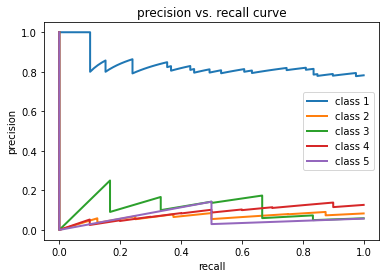

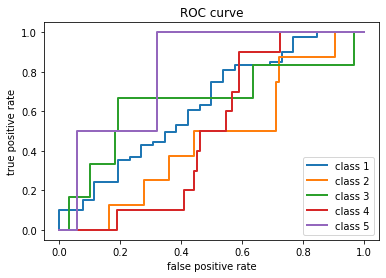

In [237]:
y_pred = random.predict_proba(X_test_transformed)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

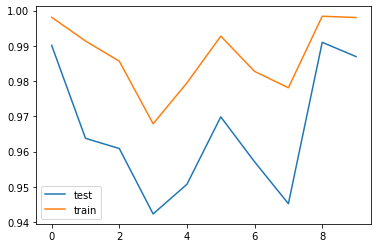

In [238]:
test_scores = random.cv_results_['mean_test_score']
train_scores = random.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [239]:
test_score = random.score(X_test_transformed, y_test)
print(test_score)

0.7523809523809524


###RandomizedSearch with RandomForest

In [240]:
steps = list()
steps.append(('model', RandomForestClassifier()))
pipeline = Pipeline(steps=steps)

In [241]:
n_estimators = [100, 200, 300]
criterion = ['gini','entropy']
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=20, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [242]:
random_result = random.fit(X_train_smote, y_train_smote)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


In [243]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.985507 using {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 30, 'model__criterion': 'entropy'}


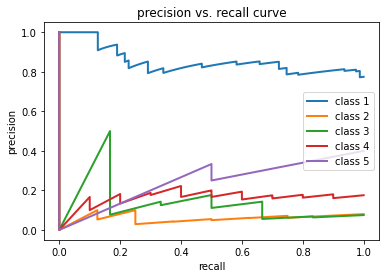

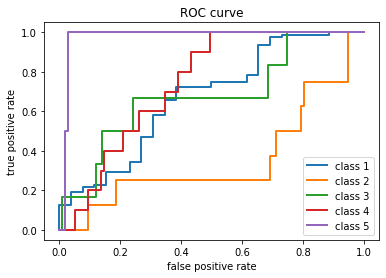

In [244]:
y_pred = random.predict_proba(X_test_transformed)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

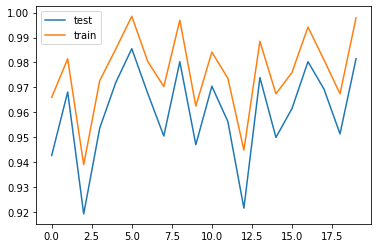

In [245]:
test_scores = random.cv_results_['mean_test_score']
train_scores = random.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [246]:
test_score = random.score(X_test_transformed, y_test)
print(test_score)

0.7523809523809524


###RandomizedSearch with XGBClassifier

In [247]:
steps = list()
steps.append(('model', XGBClassifier()))
pipeline = Pipeline(steps=steps)

In [248]:
n_estimators = [100, 200, 300]
criterion = ['gini','entropy']
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
param_grid = {'model__n_estimators':n_estimators, 'model__criterion':criterion, 'model__max_depth':max_depth, 'model__min_samples_split':min_samples_split, 'model__min_samples_leaf':min_samples_leaf}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
random = RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter=20, n_jobs=-1, return_train_score=True, cv=cv, verbose=1, scoring='accuracy')

In [249]:
random_result = random.fit(X_train_smote, y_train_smote)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 59.6min finished


In [250]:
# report the best configuration
#print("Parameters", grid.best_estimator_)
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_)) # report all configurations
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.960290 using {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': 25, 'model__criterion': 'gini'}


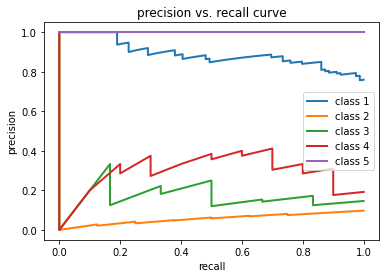

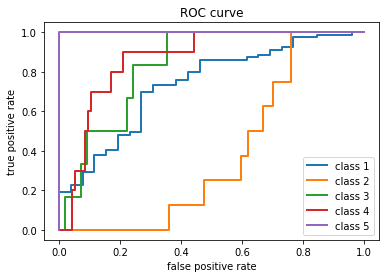

In [251]:
y_pred = random.predict_proba(X_test_transformed)
plotcurves(y_test, y_pred, 'approach', 'gridrf')

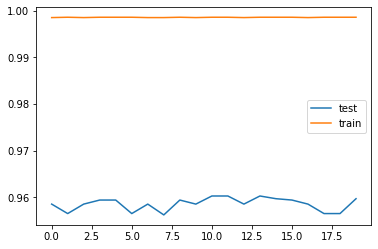

In [252]:
test_scores = random.cv_results_['mean_test_score']
train_scores = random.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [253]:
test_score = random.score(X_test_transformed, y_test)
print(test_score)

0.7142857142857143


##Summary

# The dataset was cleaned with EDA and unwanted columns removed in the previous step.

The purpose of this notebook is to tune the hyperparameters through a combination of Gridsearch and RandomizedSearch. 

We picked 4 models to tune the hyperparameters:

1. RandomForest
2. ExtraTrees
3. XGBClassifier
4. LightGBMClassifier

We evaluated the whole hyperparameter tuning on the augmented dataset as well as on the original dataset with SMOTE sampling.

In general, RandomizedSearch is significantly faster than GridSearch from computation point of view without having significant effect on the performance/accuracy.

So, other than the couple of runs, we primarily relied on RandomizedSearchCV on this notebook. 

The hyperparameters tuned are the following:

*   max_features
*   n_estimators
*   max_depth
*   loss_criterion
*   min_samples_leaf
*   min_samples_split

We have summarized the results of each approach + Grid choice.

The GridSearch with ExtraTrees is the best performing model when done on the augmented dataset with an accuracy of 0.94188 (7.7 minutes)

The RandomizedSearch with XGB is the fastest model when done on the augmented dataset with an accuracy of 0.8974 (13.4 seconds)

The RandomizedSearch with ExtraTrees is the fastest and the best performing model when done on the original dataset (SMOTE) with an accuracy of 0.99104 (34.4 seconds)

**Observation**

RandomizedSearch is generally quicker in narrowing down the best performing hyperparameters. But there are cases where the RandomSearch takes significant time (e.g., approach 2, randomizedsearch with XGB took 60 minutes, while randomizedsearch with ExtraTrees just took 34 seconds). That shows that 

**Approach 1: On the Augmented dataset**

GridSearch with RandomForestClassifier (4.1 minutes)

Best: 0.894127 using {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}

GridSearch with ExtraTreesClassifier (7.7 minutes)

Best: 0.941998 using {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}

RandomizedSearch with ExtraTrees (28.4 seconds)

Best: 0.818117 using {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'entropy'}

RandomizedSearch with LightGBMClassifier (57.3 seconds)

Best: 0.897507 using {'model__n_estimators': 300, 'model__min_samples_split': 15, 'model__min_samples_leaf': 5, 'model__max_features': 5, 'model__max_depth': None, 'model__criterion': 'gini'}

RandomizedSearch with RandomForest (38.6 seconds)

Best: 0.833889 using {'model__n_estimators': 300, 'model__min_samples_split': 15, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'entropy'}

RandomizedSearch with XGB (13.4 seconds)

Best: 0.897493 using {'model__n_estimators': 300, 'model__min_samples_split': 15, 'model__min_samples_leaf': 2, 'model__max_features': 5, 'model__max_depth': 5, 'model__criterion': 'gini'}

**Approach 2: On the original dataset + SMOTE**

RandomizedSearch with LightGBM (5.1 minutes)

Best: 0.965507 using {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 10, 'model__max_depth': None, 'model__criterion': 'gini'}

RandomizedSearch with ExtraTreesClassifier (34.4 seconds)

Best: 0.991014 using {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 15, 'model__criterion': 'entropy'}

RandomizedSearch with RandomForest (1.8 minutes)

Best: 0.985507 using {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 30, 'model__criterion': 'entropy'}


RandomizedSearch with XGBClassifier (60 minutes)

Best: 0.960290 using {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': 25, 'model__criterion': 'gini'}


